<a href="https://colab.research.google.com/github/TyxYAN/-/blob/main/CLIP_GradCAM_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP GradCAM Colab

This Colab notebook uses [GradCAM](https://arxiv.org/abs/1610.02391) on OpenAI's [CLIP](https://openai.com/blog/clip/) model to produce a heatmap highlighting which regions in an image activate the most to a given caption.

**Note:** Currently only works with the ResNet variants of CLIP. ViT support coming soon.

In [2]:
#@title Install dependencies

#@markdown Please execute this cell by pressing the _Play_ button
#@markdown on the left.

#@markdown **Note**: This installs the software on the Colab
#@markdown notebook in the cloud and not on your computer.

%%capture
!pip install ftfy regex tqdm matplotlib opencv-python scipy scikit-image
!pip install git+https://github.com/openai/CLIP.git

import urllib.request
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import clip
from PIL import Image
from scipy.ndimage import filters
from torch import nn

In [3]:
#@title Helper functions

#@markdown Some helper functions for overlaying heatmaps on top
#@markdown of images and visualizing with matplotlib.

def normalize(x: np.ndarray) -> np.ndarray:
    # Normalize to [0, 1].
    x = x - x.min()
    if x.max() > 0:
        x = x / x.max()
    return x

# Modified from: https://github.com/salesforce/ALBEF/blob/main/visualization.ipynb
def getAttMap(img, attn_map, blur=True):
    if blur:
        attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
    attn_map = normalize(attn_map)
    cmap = plt.get_cmap('jet')
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    attn_map = 1*(1-attn_map**0.7).reshape(attn_map.shape + (1,))*img + \
            (attn_map**0.7).reshape(attn_map.shape+(1,)) * attn_map_c
    return attn_map

def viz_attn(img, attn_map, blur=True):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[1].imshow(getAttMap(img, attn_map, blur))
    for ax in axes:
        ax.axis("off")
    plt.show()

def load_image(img_path, resize=None):
    image = Image.open(img_path).convert("RGB")
    if resize is not None:
        image = image.resize((resize, resize))
    return np.asarray(image).astype(np.float32) / 255.

In [4]:
#@title GradCAM: Gradient-weighted Class Activation Mapping

#@markdown Our gradCAM implementation registers a forward hook
#@markdown on the model at the specified layer. This allows us
#@markdown to save the intermediate activations and gradients
#@markdown at that layer.

#@markdown To visualize which parts of the image activate for
#@markdown a given caption, we use the caption as the target
#@markdown label and backprop through the network using the
#@markdown image as the input.
#@markdown In the case of CLIP models with resnet encoders,
#@markdown we save the activation and gradients at the
#@markdown layer before the attention pool, i.e., layer4.

class Hook:
    """Attaches to a module and records its activations and gradients."""

    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)

    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()

    @property
    def activation(self) -> torch.Tensor:
        return self.data

    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad


# Reference: https://arxiv.org/abs/1610.02391
def gradCAM(
    model: nn.Module,
    input: torch.Tensor,
    target: torch.Tensor,
    layer: nn.Module
) -> torch.Tensor:
    # Zero out any gradients at the input.
    if input.grad is not None:
        input.grad.data.zero_()

    # Disable gradient settings.
    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)

    # Attach a hook to the model at the desired layer.
    assert isinstance(layer, nn.Module)
    with Hook(layer) as hook:
        # Do a forward and backward pass.
        output = model(input)
        output.backward(target)

        grad = hook.gradient.float()
        act = hook.activation.float()

        # Global average pool gradient across spatial dimension
        # to obtain importance weights.
        alpha = grad.mean(dim=(2, 3), keepdim=True)
        # Weighted combination of activation maps over channel
        # dimension.
        gradcam = torch.sum(act * alpha, dim=1, keepdim=True)
        # We only want neurons with positive influence so we
        # clamp any negative ones.
        gradcam = torch.clamp(gradcam, min=0)

    # Resize gradcam to input resolution.
    gradcam = F.interpolate(
        gradcam,
        input.shape[2:],
        mode='bicubic',
        align_corners=False)

    # Restore gradient settings.
    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])

    return gradcam

/tmp/ipython-input-3-715620219.py:16: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))


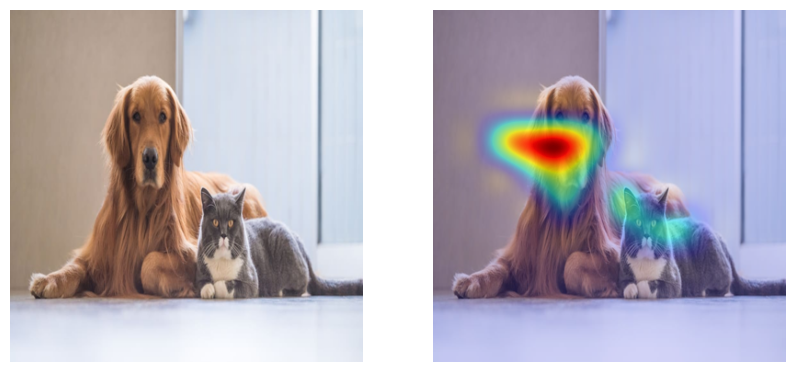

In [14]:
#@title Run

#@markdown #### Image & Caption settings
image_url = 'https://images2.minutemediacdn.com/image/upload/c_crop,h_706,w_1256,x_0,y_64/f_auto,q_auto,w_1100/v1554995050/shape/mentalfloss/516438-istock-637689912.jpg' #@param {type:"string"}

image_caption = 'the dog' #@param {type:"string"}
#@markdown ---
#@markdown #### CLIP model settings
clip_model = "RN50x16" #@param ["RN50", "RN101", "RN50x4", "RN50x16"]
saliency_layer = "layer4" #@param ["layer4", "layer3", "layer2", "layer1"]
#@markdown ---
#@markdown #### Visualization settings
blur = True #@param {type:"boolean"}

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)

# Download the image from the web.
image_path = '222.png'
#urllib.request.urlretrieve(image_url, image_path)

image_input = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
image_np = load_image(image_path, model.visual.input_resolution)
text_input = clip.tokenize([image_caption]).to(device)

attn_map = gradCAM(
    model.visual,
    image_input,
    model.encode_text(text_input).float(),
    getattr(model.visual, saliency_layer)
)
attn_map = attn_map.squeeze().detach().cpu().numpy()

viz_attn(image_np, attn_map, blur)